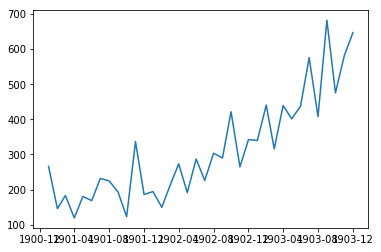

In [63]:
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from IPython.display import display as disp
from matplotlib import pyplot
import pylab 
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# load dataset
def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser,engine='python',skipfooter=2)


plt.plot(series)
plt.show()

### LSTM model

In [31]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    #df.fillna(0, inplace=True)
    df=df.dropna(axis=0, how='any')
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        diff.append(dataset[i] - dataset[i - interval])
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [54]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
supervised_values[:5]

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])

In [58]:
#model training
batch_size=1
nb_epoch=100
neurons=4

model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
lstm_model=model
    
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[ 0.27899525],
       [-0.05095892],
       [ 0.20562693],
       [-0.24049996],
       [-0.0273328 ],
       [-0.36265635],
       [-0.10039088],
       [ 0.06680226],
       [ 0.27346134],
       [-0.98627669],
       [ 0.1982877 ],
       [ 0.00871162],
       [ 0.20616296],
       [-0.24159254],
       [-0.39092821],
       [ 0.21764463],
       [-0.45531207],
       [ 0.16796389],
       [-0.37743521],
       [-0.00725516],
       [-0.74631625],
       [ 0.24836648]], dtype=float32)

In [65]:
train_result=lstm_model.predict(train_reshaped, batch_size=1)
train_result.shape

(22, 1)

In [70]:
train_scaled[:,0],1)

(22,)

In [64]:
np.column_stack((train_reshaped,))

ValueError: all the input arrays must have same number of dimensions